In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 113.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 88.9 MB/s eta 0:00:00


In [3]:
folder = "/content/gdrive/My Drive/BioNLP Project"

Dataset source: https://www.kaggle.com/datasets/infamouscoder/depression-reddit-cleaned?resource=download

In [4]:
#file_ = folder + "/depression_dataset_reddit_cleaned.csv"
file_ = folder + "/shuffled_data.csv"

In [5]:
import csv
import torch.utils

In [6]:
f = open(file_, "r")
csv_f = csv.reader(f)

next(csv_f, None)

['clean_text', 'is_depression']

In [7]:
texts = []
labels_str = []
for i, row in enumerate(csv_f):
  if i < 6000:                    
    texts.append(row[0])
    labels_str.append(row[1])

In [10]:
labels = [int(label) for label in labels_str]

In [13]:
labels = torch.Tensor(labels).to(torch.int64)

Logging in to HuggingFace

In [14]:
!pip install --upgrade huggingface_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
from huggingface_hub import notebook_login
notebook_login()

Loading MentalBERT

In [18]:
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("mental/mental-bert-base-uncased", use_auth_token=True)
mentalbert_model = AutoModel.from_pretrained("mental/mental-bert-base-uncased", use_auth_token=True)

Some weights of the model checkpoint at mental/mental-bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at mental/mental-bert-base-uncased and are newly initialized: ['bert.pooler.dense.weight', 'bert

Encoding/Feature extraction

In [19]:
encoding = [tokenizer.encode(text) for text in texts]

Token indices sequence length is longer than the specified maximum sequence length for this model (696 > 512). Running this sequence through the model will result in indexing errors


In [20]:
sizes = [len(enc) for enc in encoding if len(enc)<=512]

In [21]:
max(sizes)

512

In [22]:
import numpy as np

Finding the most optimal number of tokens

In [23]:
max_tokens = np.mean(sizes) + 2 * np.std(sizes)
max_tokens = int(max_tokens)
max_tokens

248

In [24]:
#max_tokens = 512

In [25]:
tok_dict = [tokenizer.encode_plus(
                        text,
                        add_special_tokens = True,
                        max_length = max_tokens,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                        truncation=True
                   ) for text in texts]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [26]:
ids = [tok_dict[i]['input_ids'] for i in range(len(tok_dict))] 
token_type_ids = [tok_dict[i]['token_type_ids'] for i in range(len(tok_dict))] 
attention_masks = [tok_dict[i]['attention_mask'] for i in range(len(tok_dict))]

In [27]:
from sklearn.model_selection import train_test_split

Train/test/val split

In [32]:
train_idx, val_test_idx = train_test_split(
    np.arange(len(labels)),
    test_size = 0.4,               
    shuffle = True)            

In [33]:
labels_left = list(set(np.arange(len(labels))) - set(train_idx))

In [34]:
val_idx, test_idx = train_test_split(
    labels_left,
    test_size = 0.3,               
    shuffle = True)            

In [35]:
import torch.nn.functional as F

In [36]:
labels_onehot = F.one_hot(labels, num_classes=2)            

In [37]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset 
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

One hot encoding for labels

In [38]:
labels_onehot_res = [torch.reshape(el, 
(1, 2)).to(torch.float) for el in labels_onehot]

Building the data loaders

In [39]:
train_set = TensorDataset(torch.cat([ids[i] for i in train_idx], dim = 0), 
                          torch.cat([token_type_ids[i] for i in train_idx], dim = 0),
                          torch.cat([attention_masks[i] for i in train_idx], dim=0), 
                          torch.cat([labels_onehot_res[i] for i in train_idx], dim=0))

In [40]:
test_set = TensorDataset(torch.cat([ids[i] for i in test_idx], dim = 0), 
                         torch.cat([token_type_ids[i] for i in test_idx], dim = 0),
                         torch.cat([attention_masks[i] for i in test_idx], dim=0), 
                         torch.cat([labels_onehot_res[i] for i in test_idx], dim=0))

In [41]:
val_set = TensorDataset(torch.cat([ids[i] for i in val_idx], dim = 0), 
                        torch.cat([token_type_ids[i] for i in val_idx], dim = 0), 
                        torch.cat([attention_masks[i] for i in val_idx], dim=0), 
                        torch.cat([labels_onehot_res[i] for i in val_idx], dim=0))

In [42]:
batch_size = 50

In [43]:
train_loader = DataLoader(
            train_set,
            sampler = RandomSampler(train_set),
            batch_size = batch_size
        )

In [44]:
test_loader = DataLoader(
            test_set,
            sampler = RandomSampler(test_set),
            batch_size = batch_size
        )

In [45]:
val_loader = DataLoader(
            val_set,
            sampler = RandomSampler(val_set),
            batch_size = batch_size
        )

In [46]:
from torch import nn

Building the finetuned model with MentalBERT as base

In [48]:
class MentalBERT_Class(nn.Module):

    def __init__(self, bert, batch_size, input_size, hidden_size, num_layers, dropout=0.2):

      super(MentalBERT_Class, self).__init__()

      self.bert = bert
      self.relu = nn.ReLU()
      self.softmax = nn.Softmax(dim=1)
      # dense layer 1
      self.fc1 = nn.Linear(768,50)
        
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(50,2)
      self.dropout = nn.Dropout(0.2)

      self.fc = nn.Linear(768, 2)
      
      
    
    def forward(self, ids, token_type_ids, attention_masks):
        _, out1 = self.bert(ids, 
                        token_type_ids = token_type_ids, 
                        attention_mask = attention_masks, return_dict=False)
        """
        For 2 fully connected layer finetuning

        out2 = self.relu(out1)
        out3 = self.fc1(out2)
        out3 = self.relu(out3)
        out4 = self.dropout(out3)
        #print(out1)
        out5 = self.fc2(out4)

        """
        out5 = self.fc(out1)
        return self.softmax(out5)
        

In [49]:
class Args():
  def __init__(self):
      self.test_batch_size = 25
      self.lr = 0.01
      self.momentum = 0.9
      self.seed = 1
      self.log_interval = 1              
      self.cuda = False
      self.epochs = 15                     

args = Args()

Training and testing

In [52]:
#In order to fine-tune BERT, we need to make sure that we don't change the weights through backpropagation
for param in mentalbert_model.parameters():
    param.requires_grad = False

In [53]:
model_class = MentalBERT_Class(mentalbert_model, batch_size, 15, 256, 1)

In [54]:
optimizer_class = torch.optim.AdamW(model_class.parameters(), lr = 2e-5, eps = 1e-08)

In [56]:
def train(args, model_, train_loader, optimizer, epoch):
    correct = 0
    model_class.train() 
    all_losses = []
    num_iter = 0
    for batch_idx, (ids, token_type_ids, attention_masks, target) in enumerate(train_loader):
        optimizer_class.zero_grad()
        output = model_(ids, token_type_ids, attention_masks)      
        loss = nn.functional.binary_cross_entropy(output, target)             #for binary classification
        all_losses.append(loss.detach().numpy())
        pred = output.round()
        correct += pred.eq(target.view_as(pred)).float().mean().item()    
        loss.backward()
        optimizer.step()
        # print the training loss of each batch
        num_iter+=1
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(ids), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
    train_accuracy = 100. * correct / num_iter
    return np.array(all_losses).mean(), train_accuracy



def test(args, model, test_loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        num_iter = 0
        losses = []
        for ids, token_type_ids, attention_masks, target in test_loader:
            output = model(ids, token_type_ids, attention_masks)
            loss = nn.functional.binary_cross_entropy(output, target)
            losses.append(loss)
            pred = output.round()
            correct += pred.eq(target.view_as(pred)).float().mean().item()
            num_iter += 1
    test_accuracy = 100. * correct / num_iter
    # print the Accuracy for the entire dataset
    test_loss = torch.mean(torch.Tensor(losses))
    print('\nTest set: Average loss: {:.4f}, Accuracy: ({:.0f}%)\n'.format(
        test_loss,
        test_accuracy))
    return test_loss, test_accuracy


In [61]:
import matplotlib.pyplot as plt

Plotting the result

Train Epoch: 1 [0/3600 (0%)]	Loss: 0.682142
Train Epoch: 1 [50/3600 (1%)]	Loss: 0.674285
Train Epoch: 1 [100/3600 (3%)]	Loss: 0.665255
Train Epoch: 1 [150/3600 (4%)]	Loss: 0.673296
Train Epoch: 1 [200/3600 (6%)]	Loss: 0.680859
Train Epoch: 1 [250/3600 (7%)]	Loss: 0.691731
Train Epoch: 1 [300/3600 (8%)]	Loss: 0.658797
Train Epoch: 1 [350/3600 (10%)]	Loss: 0.668258
Train Epoch: 1 [400/3600 (11%)]	Loss: 0.674930
Train Epoch: 1 [450/3600 (12%)]	Loss: 0.679579
Train Epoch: 1 [500/3600 (14%)]	Loss: 0.670850
Train Epoch: 1 [550/3600 (15%)]	Loss: 0.667971
Train Epoch: 1 [600/3600 (17%)]	Loss: 0.662514
Train Epoch: 1 [650/3600 (18%)]	Loss: 0.665014
Train Epoch: 1 [700/3600 (19%)]	Loss: 0.668562
Train Epoch: 1 [750/3600 (21%)]	Loss: 0.654636
Train Epoch: 1 [800/3600 (22%)]	Loss: 0.671678
Train Epoch: 1 [850/3600 (24%)]	Loss: 0.661977
Train Epoch: 1 [900/3600 (25%)]	Loss: 0.670975
Train Epoch: 1 [950/3600 (26%)]	Loss: 0.669114
Train Epoch: 1 [1000/3600 (28%)]	Loss: 0.661415
Train Epoch: 1 [1050/3

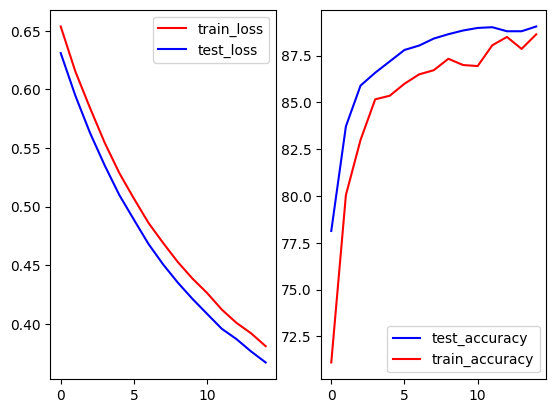

In [62]:
def plot_loss(loss, label, color='blue'):
    plt.plot(loss, label=label, color=color)
    plt.legend()


losses_train = []
losses_test = []
accuracy_test = []
accuracy_train = []
for epoch in range(1, args.epochs + 1):
    train_loss, train_accuracy = train(args, model_class, train_loader, optimizer_class, epoch)
    test_loss, test_accuracy = test(args, model_class, val_loader)
    losses_train.append(train_loss)
    losses_test.append(test_loss)
    accuracy_test.append(test_accuracy)
    accuracy_train.append(train_accuracy)


torch.save(model_class, folder + "/mentalbert_finetuned.pt")


#plot the loss/accuracy    
plt.figure()
plt.subplot(121)
plot_loss(losses_train,'train_loss','red')
plot_loss(losses_test,'test_loss')
plt.subplot(122)
plot_loss(accuracy_test,'test_accuracy')
plot_loss(accuracy_train, "train_accuracy", 'red')